In [281]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [224]:
import os
import pandas as pd
import numpy as np
import json

# Retrieve data
___
Sourced from Golden Cheetah Open Data Project

In [78]:
if 'apple' in os.environ['BUILD']:
    root_dir = '../gc_opendata-samples'
else:
    root_dir = 'E:\gc_opendata'

In [270]:
class open_dataset(object):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.athlete_ids = self.get_athlete_ids()
    def get_athlete_ids(self):
        for a,b,c in os.walk(self.root_dir):
            athletes = b
            athletes.remove('INDEX') if 'INDEX' in athletes else 0
            break
        return athletes

    def get_athlete_summary(self, athlete_id, make_float = True):
        ath_summary_path = self._athlete_summary_path(athlete_id=athlete_id)
        with open(ath_summary_path, 'r') as f:
            summary_json = f.read()
        f.close()
        rides = json.loads(summary_json)['RIDES']
        df = pd.json_normalize(rides)
        if make_float:
            for col in df.columns.tolist():
                if 'METRIC' in col:
                    if type(df[col].dropna().values[0]) == str:
                        df[col] = self._safe_convert(original_series=df[col], type_convert=float)
                    elif type(df[col].dropna().values[0]) == list:
                        try:
                            df = pd.concat([df, self._safe_list_decompression(original_series=df[col], type_convert=float)], axis=1)
                            # del df[col]
                        except:
                            print(f'{col}--fail')
                    else:
                        None
        return df
    
    def get_athlete_activity_files(self, athlete_id: str) -> list:
        athlete_dir = self._athlete_dir(athlete_id=athlete_id)
        for a, b, c in os.walk(athlete_dir):
            raw_files = c
        activity_files = []
        [activity_files.append(file) if '.csv' in file else 0  for file in raw_files]
        return activity_files
    
    def _athlete_dir(self, athlete_id: str) -> str:
        athlete_dir = os.path.join(self.root_dir, athlete_id)
        return athlete_dir

    def _athlete_summary_path(self, athlete_id: str)  -> str:
        summary_filename = "{" + athlete_id + "}.json"
        ath_summary_path = os.path.join(self.root_dir, athlete_id, summary_filename)
        return ath_summary_path
    
    @staticmethod
    def _safe_convert(original_series: pd.Series, type_convert: type) -> pd.Series:
        try:
            new_series = original_series.astype(type_convert)
            return new_series
        except:
            return original_series
    @staticmethod
    def _safe_list_decompression(original_series: pd.Series,  type_convert: type) -> pd.DataFrame:
        metric_base_name = original_series.name
        def safe_split(val):
            if type(val) == list:
                return float(val[0]), float(val[1])
            elif type(val) == str:
                return float(val)
            else:
                return 0, 0
        decompressed_df = pd.DataFrame([original_series.apply(lambda x: safe_split(x))],columns=[f'{metric_base_name}_value',f'{metric_base_name}_duration'])
        return decompressed_df



In [271]:
od = open_dataset(root_dir)
ov = od.get_athlete_summary(od.athlete_ids[2])
ov.columns = [col.replace('METRICS.','') for col in ov.columns]
l = ov[ov['sport'] == 'Bike']

<AxesSubplot:>

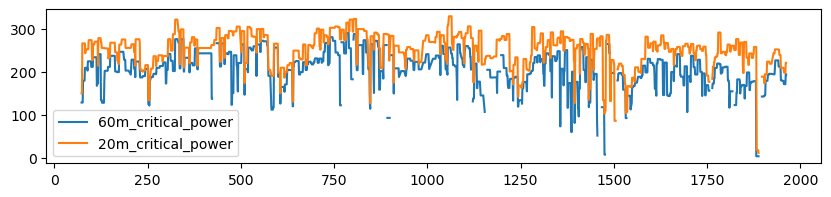

In [287]:
l[['60m_critical_power'
,'20m_critical_power']].rolling(window=7,min_periods=1).max().plot(figsize=(10,2))

# Sample Explore

In [ ]:
target_id = "7567ac31-d479-4b25-9538-541ae8085288"
act_samp = activ_sum[activ_sum['id'] == target_id].copy()
act_samp.columns.tolist()

In [ ]:
act_samp['athlete_weight'] = act_samp['20m_critical_power']/act_samp['20m_peak_wpk']
act_samp['athlete_weight'] = act_samp['athlete_weight'].ffill().bfill()
act_samp.set_index('date',inplace=True)
act_samp[act_samp['sport'] == 'Bike']['20m_critical_power'].rolling(window=90, min_periods=1).max().plot();
act_samp.plot(kind='scatter',x='workout_time',y='average_hr')

In [ ]:
def calc_vo2(row, max_hr, resting_hr):
    if row['sport'] == 'Bike':
        percent_vo2 = (row['average_hr'] - resting_hr)/(max_hr - resting_hr)
        vo2_estimated = (((row['average_power']/75)*1000)/row['athlete_weight']) / percent_vo2
        # vo2_estimated = row['VO2max_Detected'] ## overide with Garmin VO2 Estimation
    elif row['sport'] == 'Run':
        percent_vo2 = (row['average_hr'] - resting_hr)/(max_hr - resting_hr)
        vo2_estimated = (210/row['average_speed']) / percent_vo2
    else:
        vo2_estimated =  0
    return vo2_estimated
act_samp['VO2'] = act_samp.apply(lambda row: calc_vo2(row, 179, 45), axis=1)

# Modeling

In [278]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [279]:
class TimeSeriesCNN(nn.Module):
    def __init__(self):
        super(TimeSeriesCNN, self).__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64*8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        # Pass the input through the layers of the CNN
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64*8)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [288]:
l

,date,data,sport,a_skiba_xpower,a_skiba_relative_intensity,a_skiba_bike_score,a_skiba_variability_index,a_coggan_np,a_coggan_if,a_coggan_tss,...,percent_in_zone_H10_value,percent_in_zone_H10_duration,heart.rate_dist_value,heart.rate_dist_duration,heart.rate_dist_bins_value,heart.rate_dist_bins_duration,climb_rating_value,climb_rating_duration,left_right_balance_value,left_right_balance_duration
73,2013/05/24 15:52:24 UTC,TDSPHC-AGL-E---,Bike,"[168.00812, 7849.00000]","[0.56952, 7849.00000]",70.71774,1.32609,"[198.64825, 7230.00000]","[0.67338, 7230.00000]",91.06705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,2013/05/25 18:11:17 UTC,TDSPHC-AGL-E---,Bike,"[130.74341, 2277.00000]","[0.44320, 2277.00000]",12.42385,1.75223,"[170.28181, 1704.00000]","[0.57723, 1704.00000]",15.77101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,2013/05/25 18:57:08 UTC,TDSPHC-AGL-E---,Bike,"[274.10420, 1452.00000]","[0.92917, 1452.00000]",34.82182,1.05045,"[286.42758, 1452.00000]","[0.97094, 1452.00000]",38.02329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,2013/05/26 11:33:57 UTC,TDSPHC-AGL-E---,Bike,"[67.45012, 1306.00000]","[0.22864, 1306.00000]",1.89654,1.50428,"[79.47674, 1001.00000]","[0.26941, 1001.00000]",2.01822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,2013/05/26 11:59:13 UTC,TDSPHC-AGL-E---,Bike,"[197.65821, 11956.00000]","[0.67003, 11956.00000]",149.09706,1.16718,"[214.74616, 11956.00000]","[0.72795, 11956.00000]",175.99090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,2020/02/17 22:54:20 UTC,TDS----AGL-----,Bike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959,2020/02/19 12:15:51 UTC,TDS----AGL-----,Bike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960,2020/02/19 21:37:39 UTC,TDS----AGL-----,Bike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,2020/02/20 00:18:34 UTC,TDSP-C-AGL-EV--,Bike,"[203.60084, 7521.00000]","[0.70207, 7521.00000]",102.97605,1.17737,"[211.69884, 7331.00000]","[0.73000, 7331.00000]",108.51798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
input_data = fl_df[['TIZ1_3','TIZ2_3','TIZ3_3','VO2_l1']].to_numpy()[:-1]
target_data = fl_df['VO2'][:-1].to_numpy()

In [ ]:
test_percent = 0.8
test_split = int(input_data.shape[0] * test_percent)
train_input_data, train_target_data = input_data[:test_split], target_data[:test_split]
test_input_data, test_target_data = input_data[test_split:], target_data[test_split:]

In [ ]:
model = TimeSeriesCNN()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    inputs = torch.from_numpy(train_input_data[:32].T).float()
    targets = torch.from_numpy(train_target_data).float()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    # Evaluate the model on the test set
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            inputs = torch.from_numpy(test_data).float()
            targets = torch.from_numpy(test_labels).float()
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            print(f"Epoch {epoch}: Test loss = {test_loss.item()}")

In [277]:
# Generic NN
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)
        self.fc3 = nn.Linear(2, 1)
         
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
net = NN()
print(net)

NameError: name 'nn' is not defined